In [2]:
import numpy
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
import os

filename = '../dataset/wonderland.txt'
raw_text = open(filename).read().lower()

In [3]:
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
print('number of letters: ', len(char_to_int))
print(char_to_int)

number of letters:  47
{'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, '(': 5, ')': 6, '*': 7, ',': 8, '-': 9, '.': 10, '0': 11, '1': 12, '3': 13, ':': 14, ';': 15, '?': 16, '[': 17, ']': 18, '_': 19, '`': 20, 'a': 21, 'b': 22, 'c': 23, 'd': 24, 'e': 25, 'f': 26, 'g': 27, 'h': 28, 'i': 29, 'j': 30, 'k': 31, 'l': 32, 'm': 33, 'n': 34, 'o': 35, 'p': 36, 'q': 37, 'r': 38, 's': 39, 't': 40, 'u': 41, 'v': 42, 'w': 43, 'x': 44, 'y': 45, 'z': 46}


In [4]:
import string
string.ascii_lowercase
# string.digits
# string.punctuation
chars_new = list(string.ascii_lowercase) + ['0', '.', ',', ' ', '!', '?', 'unk']
chars_to_int = dict((v, k) for k, v in enumerate(chars_new))
int_to_chars = dict((k, v) for k, v in enumerate(chars_new))
print('char_to_int: ', chars_to_int)
print('int_to_char: ', int_to_chars)
# def _clean_chars(text):
#     return 1

char_to_int:  {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, '0': 26, '.': 27, ',': 28, ' ': 29, '!': 30, '?': 31, 'unk': 32}
int_to_char:  {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: '0', 27: '.', 28: ',', 29: ' ', 30: '!', 31: '?', 32: 'unk'}


In [5]:
n_chars = len(raw_text)
n_vocab = len(chars_new)
print('Total Characters: ', n_chars)
print('Total Vocab: ', n_vocab)

Total Characters:  148576
Total Vocab:  33


In [6]:
def _encode_sen(text):
    text = text.lower()
    sen_vec = []
    for let in text:
        if let in chars_new[:-1]:
            idx = chars_to_int[let]
        else:
            idx = chars_to_int["unk"]
        sen_vec.append(idx)
    return sen_vec


x_test = _encode_sen("Alice is a wonderful story, #")
print(x_test)

[0, 11, 8, 2, 4, 29, 8, 18, 29, 0, 29, 22, 14, 13, 3, 4, 17, 5, 20, 11, 29, 18, 19, 14, 17, 24, 28, 29, 32]


In [7]:
def _decode_sen(vec):
    text = []
    for i in vec:
        let = int_to_chars[i]
        text.append(let)
    text = ''.join(text)
    return text

_decode_sen(x_test)

'alice is a wonderful story, unk'

In [8]:
# prepare the dataser of input to output pairs encoded as integers
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    # Lấy ra 100 ký tự liền trước
    seq_in = raw_text[i:i + seq_length]
    # Lấy ra ký tự liền sau 100 ký tự đó
    seq_out = raw_text[i + seq_length]
    dataX.append(_encode_sen(seq_in))
    dataY.append(_encode_sen(seq_out)[0])
    n_patterns = len(dataX)
print('Total Patterns: ', n_patterns)

Total Patterns:  148476


In [9]:
# reshape X to be [samples, time steps, features]
X_train = numpy.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X_train = X_train / float(n_vocab)
# one hot encode the output variable
y_train = to_categorical(dataY)
print("X [samples, time steps, features] shape: ", X_train.shape)
print("Y shape: ", y_train.shape)
print(type(X_train))
print(type(y_train))

X [samples, time steps, features] shape:  (148476, 100, 1)
Y shape:  (148476, 33)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


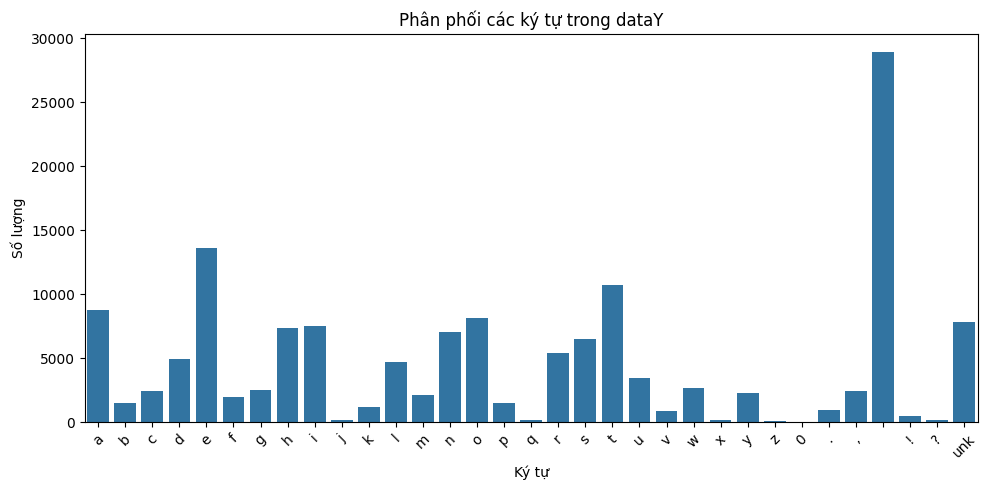

In [10]:
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Vẽ biểu đồ đếm
sn.countplot(x=np.array(dataY))

# Đặt nhãn trục x
plt.xticks(np.arange(33), np.array(chars_new), rotation=45)

# Thêm tiêu đề và nhãn trục
plt.title("Phân phối các ký tự trong dataY")
plt.xlabel("Ký tự")
plt.ylabel("Số lượng")

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


In [16]:
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

c:\Data\VScode-Workspace\CapstoneProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 33)             │         8,481 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 272,673 (1.04 MB)

 Trainable params: 272,673 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
filepath = "models/weights-improvement-{epoch:02d}-{loss:.4f}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callback_list = [checkpoint]

In [23]:
model.fit(X_train, y_train, epochs=5, batch_size=128, verbose=1, validation_split=0.33, callbacks=callback_list)

Epoch 1/5
778/778 ━━━━━━━━━━━━━━━━━━━━ 139s 179ms/step - accuracy: 0.2869 - loss: 2.4947 - val_accuracy: 0.2894 - val_loss: 2.4940
Epoch 2/5


c:\Data\VScode-Workspace\CapstoneProject\.venv\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


778/778 ━━━━━━━━━━━━━━━━━━━━ 135s 173ms/step - accuracy: 0.3001 - loss: 2.4418 - val_accuracy: 0.2981 - val_loss: 2.4523
Epoch 3/5
778/778 ━━━━━━━━━━━━━━━━━━━━ 133s 170ms/step - accuracy: 0.3133 - loss: 2.3905 - val_accuracy: 0.3112 - val_loss: 2.4261
Epoch 4/5
778/778 ━━━━━━━━━━━━━━━━━━━━ 128s 164ms/step - accuracy: 0.3295 - loss: 2.3351 - val_accuracy: 0.3206 - val_loss: 2.3903
Epoch 5/5
778/778 ━━━━━━━━━━━━━━━━━━━━ 128s 165ms/step - accuracy: 0.3467 - loss: 2.2772 - val_accuracy: 0.3218 - val_loss: 2.3808


In [25]:
import numpy as np
base_word = 'Alice was begining to get very tired of sitting by her sister on the bank'

def _predict_let(text, len_sen = 1):
    text_for = []
    for i in range(len_sen):
        x_input = np.array(_encode_sen(text)[-100:])/float(n_vocab)
        if x_input.shape[0] < 100:
            x_input = np.concatenate((np.zeros(100 - x_input.shape[0]), x_input), axis = 0)
        x_input = np.expand_dims(np.expand_dims(x_input, -1), 0)
        y_prob = model.predict(x_input)
        y_let = int_to_chars[np.argmax(y_prob, axis = 1)[0]]
        text = text + y_let
    return text[len_sen:]

_predict_let(base_word, 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

' the gotnd tee  hn she was  ou toene  ou the  ant  and the  ant  and the '